# Quantum K-Nearest Neighbors: Utilizing QRAM and SWAP-Test Techniques for Enhanced Performance


## Classical algorithm

The classical K-NN classification algorithm, extensively utilized in supervised learning, relies on two datasets: a training set containing labeled samples and a test set consisting of unlabeled ones. To classify each test sample, the algorithm employs a similarity metric, typically a distance metric in feature space.


the classical algorithm is shown as an image and pseudocode:


<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Classical K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set. <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the training set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Compute the distance between the test event and training event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Find the K nearest neighbors to the test event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure1.png" alt="example of K-NN" style=" height: 233px; width:621px;  display: block; margin-left: auto;   margin-right: auto;"  />

## Quantum proposal

### Dependencies 


This quantum algorithm uses qiskit, numpy, skelearn  and seaborn as dependencies to run the cide.

In [1]:
# import sklearn to load the iris dataset and split the dataset in train and test model, and the metric confusion matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import pandas to use seaborn plots as hue parameter
import pandas as pd

# import seaborn to plot the iris dataset
import seaborn as sns

# import numpy for postprocessing to find the k-nn label
import numpy as np

#module to find the mode
import operator

# import qiskit minimal methods to use quantum circuit and use qubits as the classical bits
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Dataset

Obtained  iris dataset from sklearn using dataset module. The iris dataset is used, which has 3 classes: **Iris-setosa**,**Iris-versicolor**,**Iris-virginica**, each with 50 instances, resulting in a total of 150.


In [2]:
iris = datasets.load_iris()

This dataset plot using Seaborn module, a dataframe is required to read the variables, denoted as 'var1', 'var2', 'var3', and 'var4', along with the 'class' for color differentiation. Additionally, the chosen color palette is 'Paired'. 

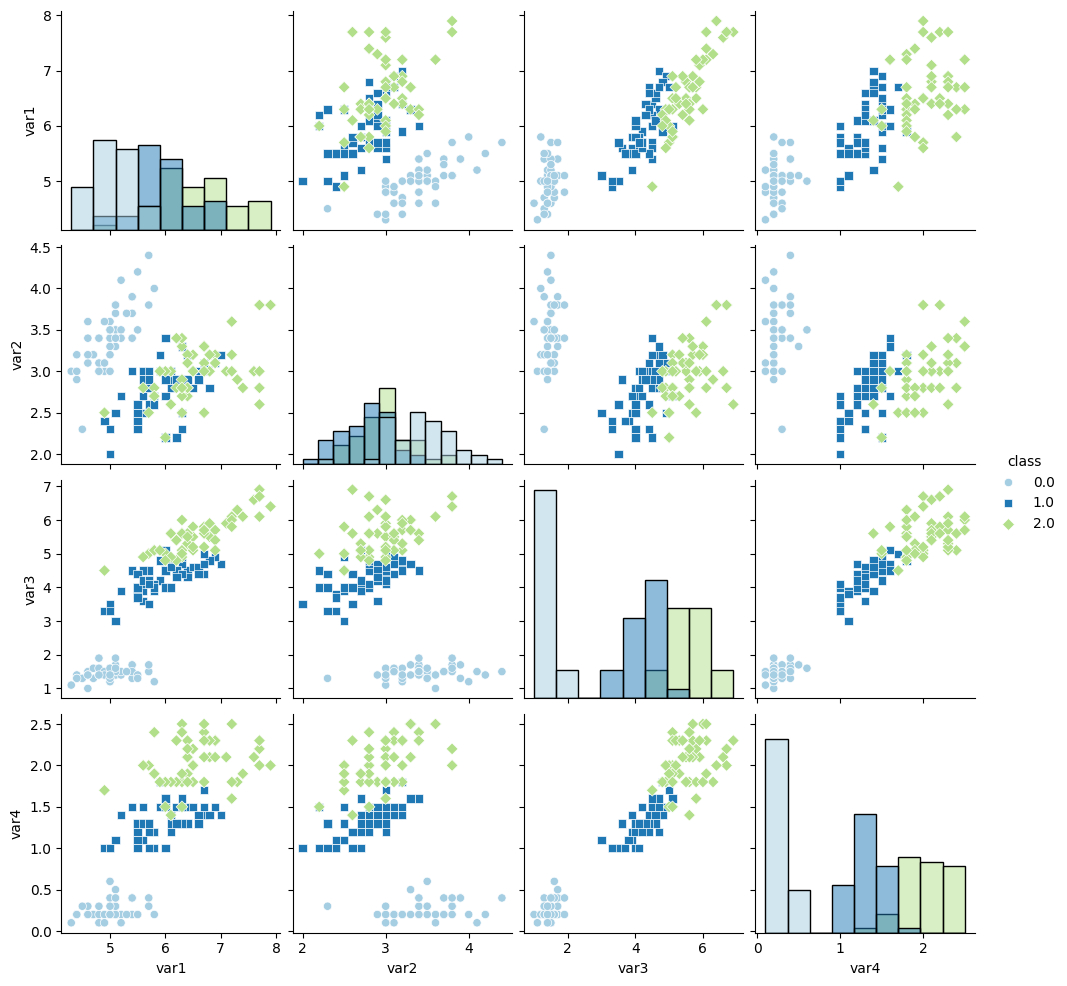

In [3]:
df_iris = pd.DataFrame(np.append(iris['data'],np.atleast_2d(iris['target']).T, axis=1))
df_iris.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

The hold-out method is used, with a split of 70% for the training set and 30% for the test set.

In [4]:
x_train, x_test, y_train, y_test =train_test_split(iris['data'], iris['target'], train_size=0.7, test_size=0.3, random_state=13)

In [5]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 105
Number of original test examples: 45


# The quantum algorithm

The QK-NN is based on three critical components: data storage in QRAM, the similarity metric from the SWAP-Test quantum circuit, and grouping both of those to allow Grover's algorithm to increase the probability of selecting states with higher similarity as shown in the following Pseudocode and Figure

<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Quantum K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set.<br> 
    &nbsp;&nbsp;&nbsp;&nbsp; Apply angle encoding to the features of both datasets <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Load the training set into QRAM. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Initialize the oracle qubit to the state $|-\rangle$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure7.png">

##### Integer to binary

The first method using is generate a function to convert a integer value i na bin representation to qiskit, this  works to generate the control qubits needed for the QRAM

In [6]:
def indexPosicion(value):
    list_bin = []
    temp = bin(value)[2:]
    temp = temp[::-1]
    for i in range(len(temp)):
        if temp[i] == '1':
            list_bin.append(i)
    return list_bin

For example, the number 4 convert in 100, but the index position in a QRAM is 2 for the format q0q1q2, where q2 is  the position.

In [7]:
indexPosicion(4)

[2]

#### The diffuser

Is a quantum circuit used in Grover's algorithm that do a reflection operation to consider in this algorithm only the train state more similar with  the test set's instance

In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

For example a diffuser of 3 qubits where using a mcx gate changed to mcz  with the equivalence HXH = Z.

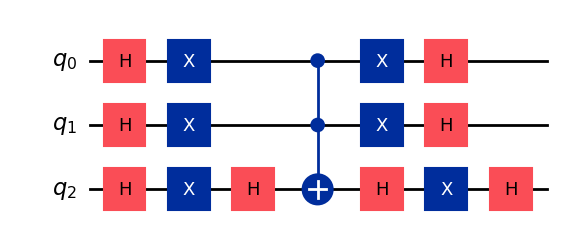

In [9]:
nqubits = 3
def example_diffuser(nqubits):
    qc_d = QuantumCircuit(nqubits)
    qc_d.append(diffuser(nqubits),range(nqubits))
    return qc_d
example_diffuser(nqubits).decompose().draw("mpl")

#### The QRAM and QRAM$^{\dagger}$ 


This is a method using a MCX to save the train set, the size must be $2^m$, $m$ is the number of qubits address. a And save the information in $n$ qubits features· 

In [10]:
def qram(qc,address,ancilla,data,train_set,len_arr):
    if len_arr > len(train_set):
        len_arr = len(train_set)
    for i in range(len_arr):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.crz(angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
            qc.x(address[x_gates_array])
        else:
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.crz(angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
 
        qc.barrier()

For example a QRAM of 2 qubits address and the first four elements of iris train set.

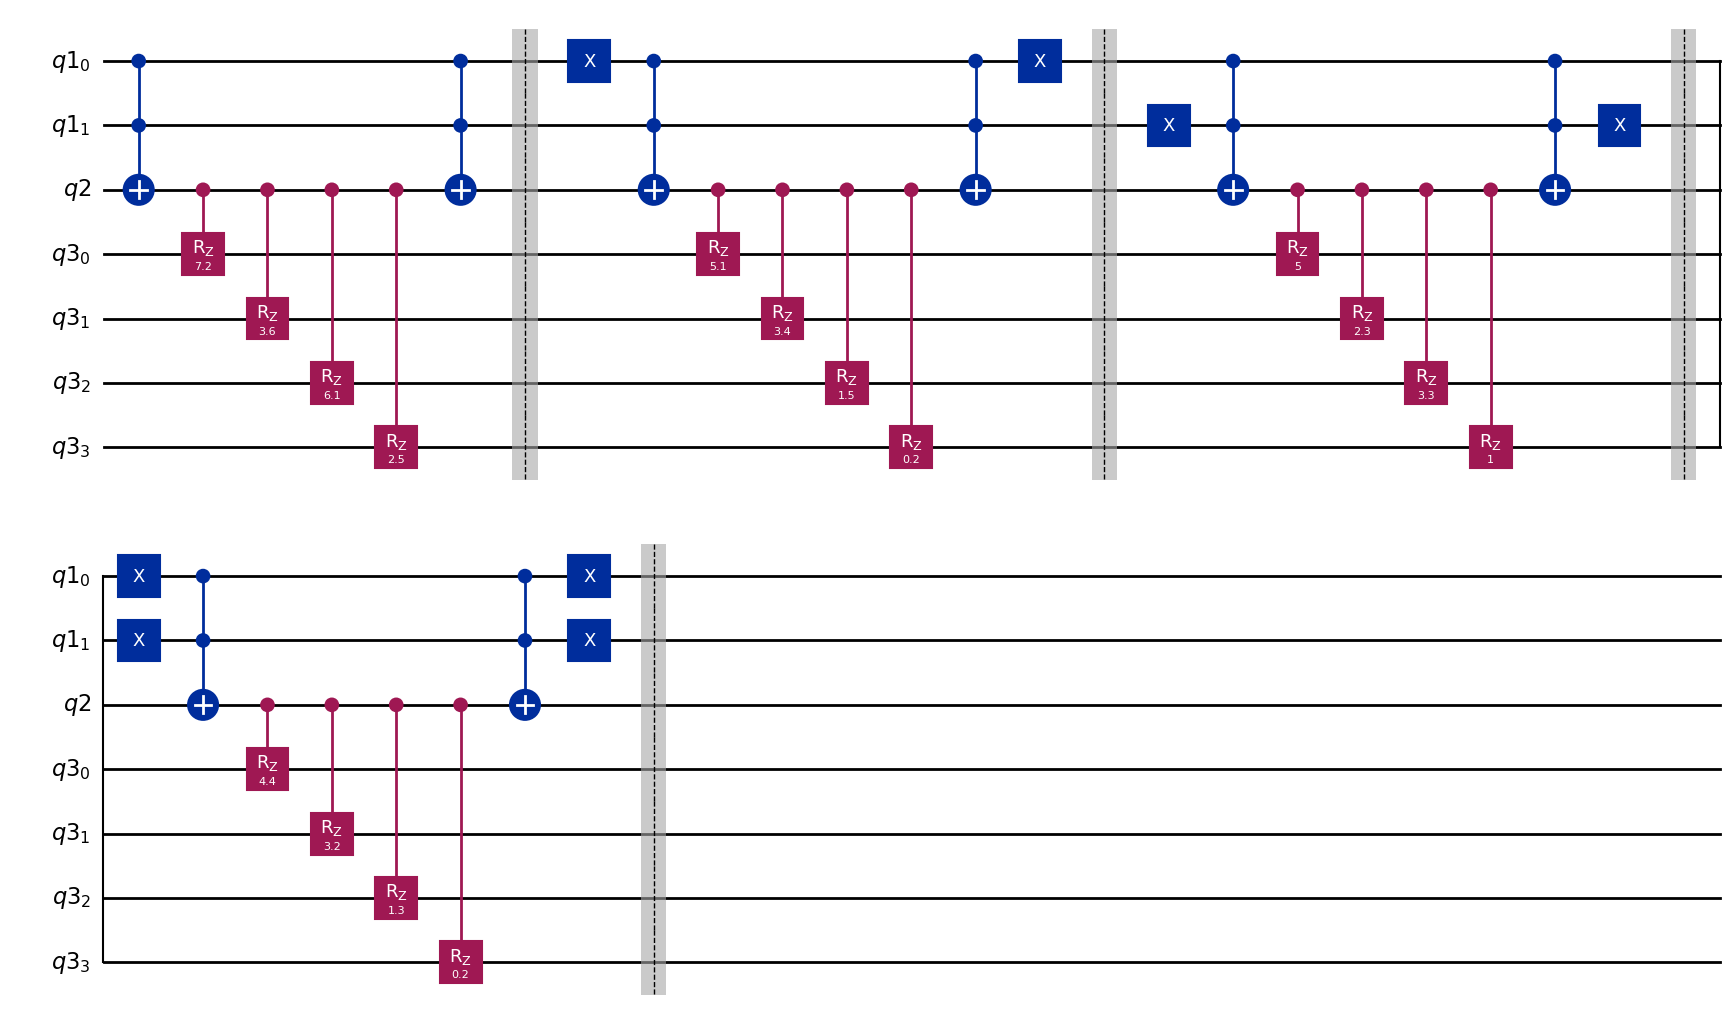

In [11]:
size_QRAM = 2
features = 4

train_set = x_train[:4]

def example_qram(size_QRAM,features,train_set):
    
    n = (2**size_QRAM)
    
    address = QuantumRegister(size_QRAM)
    ancilla = QuantumRegister(1)
    data_train = QuantumRegister(features)

    
    qc_qram = QuantumCircuit(address,ancilla,data_train)

    
    qram(qc_qram,address,ancilla,data_train,train_set,n)
    #qc_d.append(diffuser(nqubits),range(nqubits))
    return qc_qram

example_qram(size_QRAM,features,train_set).draw("mpl")

In [12]:
def qram_d(qc,address,ancilla,data,train_set,len_arr):
    if len_arr > len(train_set):
        len_arr = len(train_set)
    for i in range(len_arr):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.crz(-angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
            qc.x(address[x_gates_array])
        else:
            qc.mcx(address,ancilla)
            angles = train_set[i]
            for index in range(len(angles)):
                qc.crz(-angles[index],ancilla, data[index])
            qc.mcx(address,ancilla)
        qc.barrier()

For example a QRAM$^{\dagger}$ of 2 qubits address and the first four elements of iris train set.

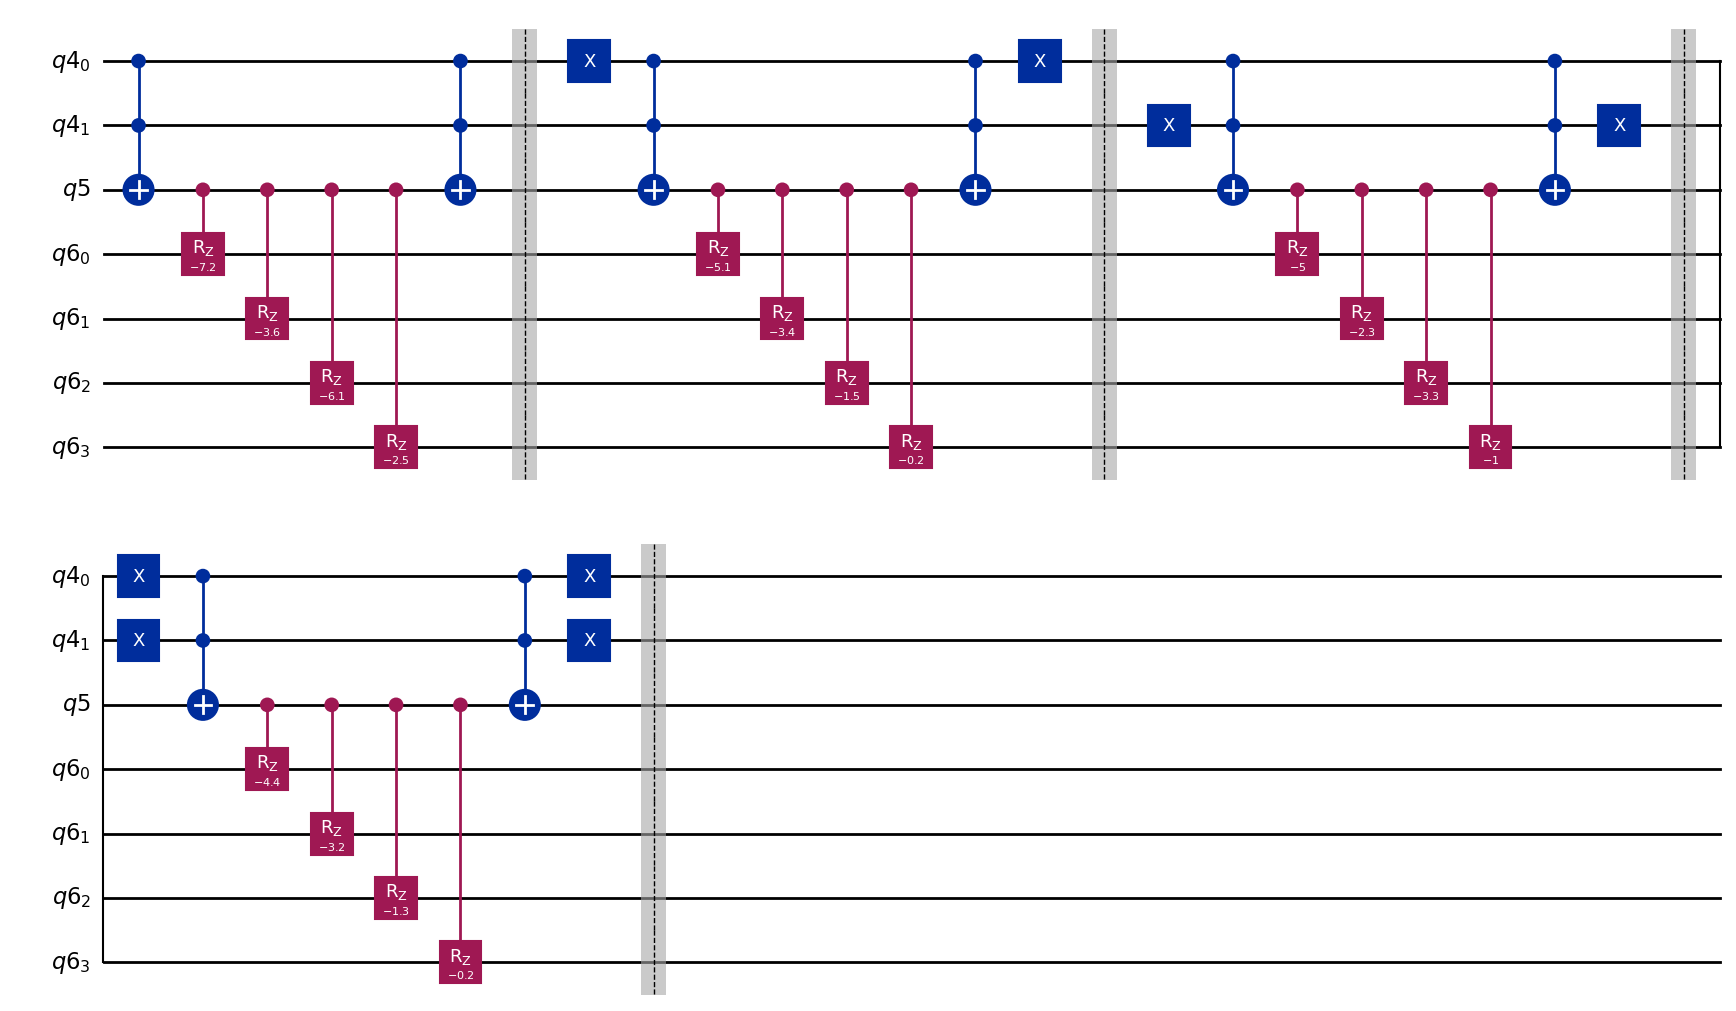

In [13]:
size_QRAM = 2
features = 4

train_set = x_train[:4]

def example_qram_dg(size_QRAM,features,train_set):
    
    n = (2**size_QRAM)
    
    address = QuantumRegister(size_QRAM)
    ancilla = QuantumRegister(1)
    data_train = QuantumRegister(features)

    
    qc_qram_dg = QuantumCircuit(address,ancilla,data_train)

    
    qram_d(qc_qram_dg,address,ancilla,data_train,train_set,n)
    return qc_qram_dg

example_qram_dg(size_QRAM,features,train_set).draw("mpl")

#### Integrate all in a QK-NN quantum circuit

Using the previous function and the diagram to design the Quantum Circuit added the SWAP-Test with intermediate measurement that is activate when is the value 0.

In [20]:
def qknn(input_a, train_set,y_train,size):
    address = QuantumRegister(size)
    ancilla = QuantumRegister(1)
    data_train = QuantumRegister(4)
    data_test = QuantumRegister(4)
    swap_test = QuantumRegister(1)
    oracle = QuantumRegister(1)
    c = ClassicalRegister(size)
    c_oracle = ClassicalRegister(1)
    qc = QuantumCircuit(address, ancilla, data_train, data_test, swap_test,oracle, c,c_oracle)

    qc.h(address)
    qc.x(oracle)
    qc.h(oracle)
    qc.h(swap_test)
    qc.h(data_train)
    qc.barrier()
    
    
    n = (2**size)
    for index in range(1):

        
            
        qram(qc,address,ancilla,data_train,train_set,n)
        qc.barrier()
        angles = input_a

        #test train
        for index in range(len(angles)):
            qc.h(data_test[index])
            qc.rz(angles[index],data_test[index]) 
        qc.barrier()


        #SWAP-Test
        for i in range(4):
            qc.cswap(swap_test[0],data_train[i],data_test[i])
        qc.h(swap_test)
        qc.barrier()

        qc.measure(swap_test,c_oracle)
        qc.x(oracle).c_if(c_oracle[0], 0)

        qc.barrier()
        qram_d(qc,address,ancilla,data_train,train_set,n)
        qc.barrier()    
        qc.append(diffuser(size),address)
        qc.barrier() 

    qc.x(address)
    qc.measure(address,c)
    
    return qc

Example with 2 qubits of the QK-NN of the first 4 features.

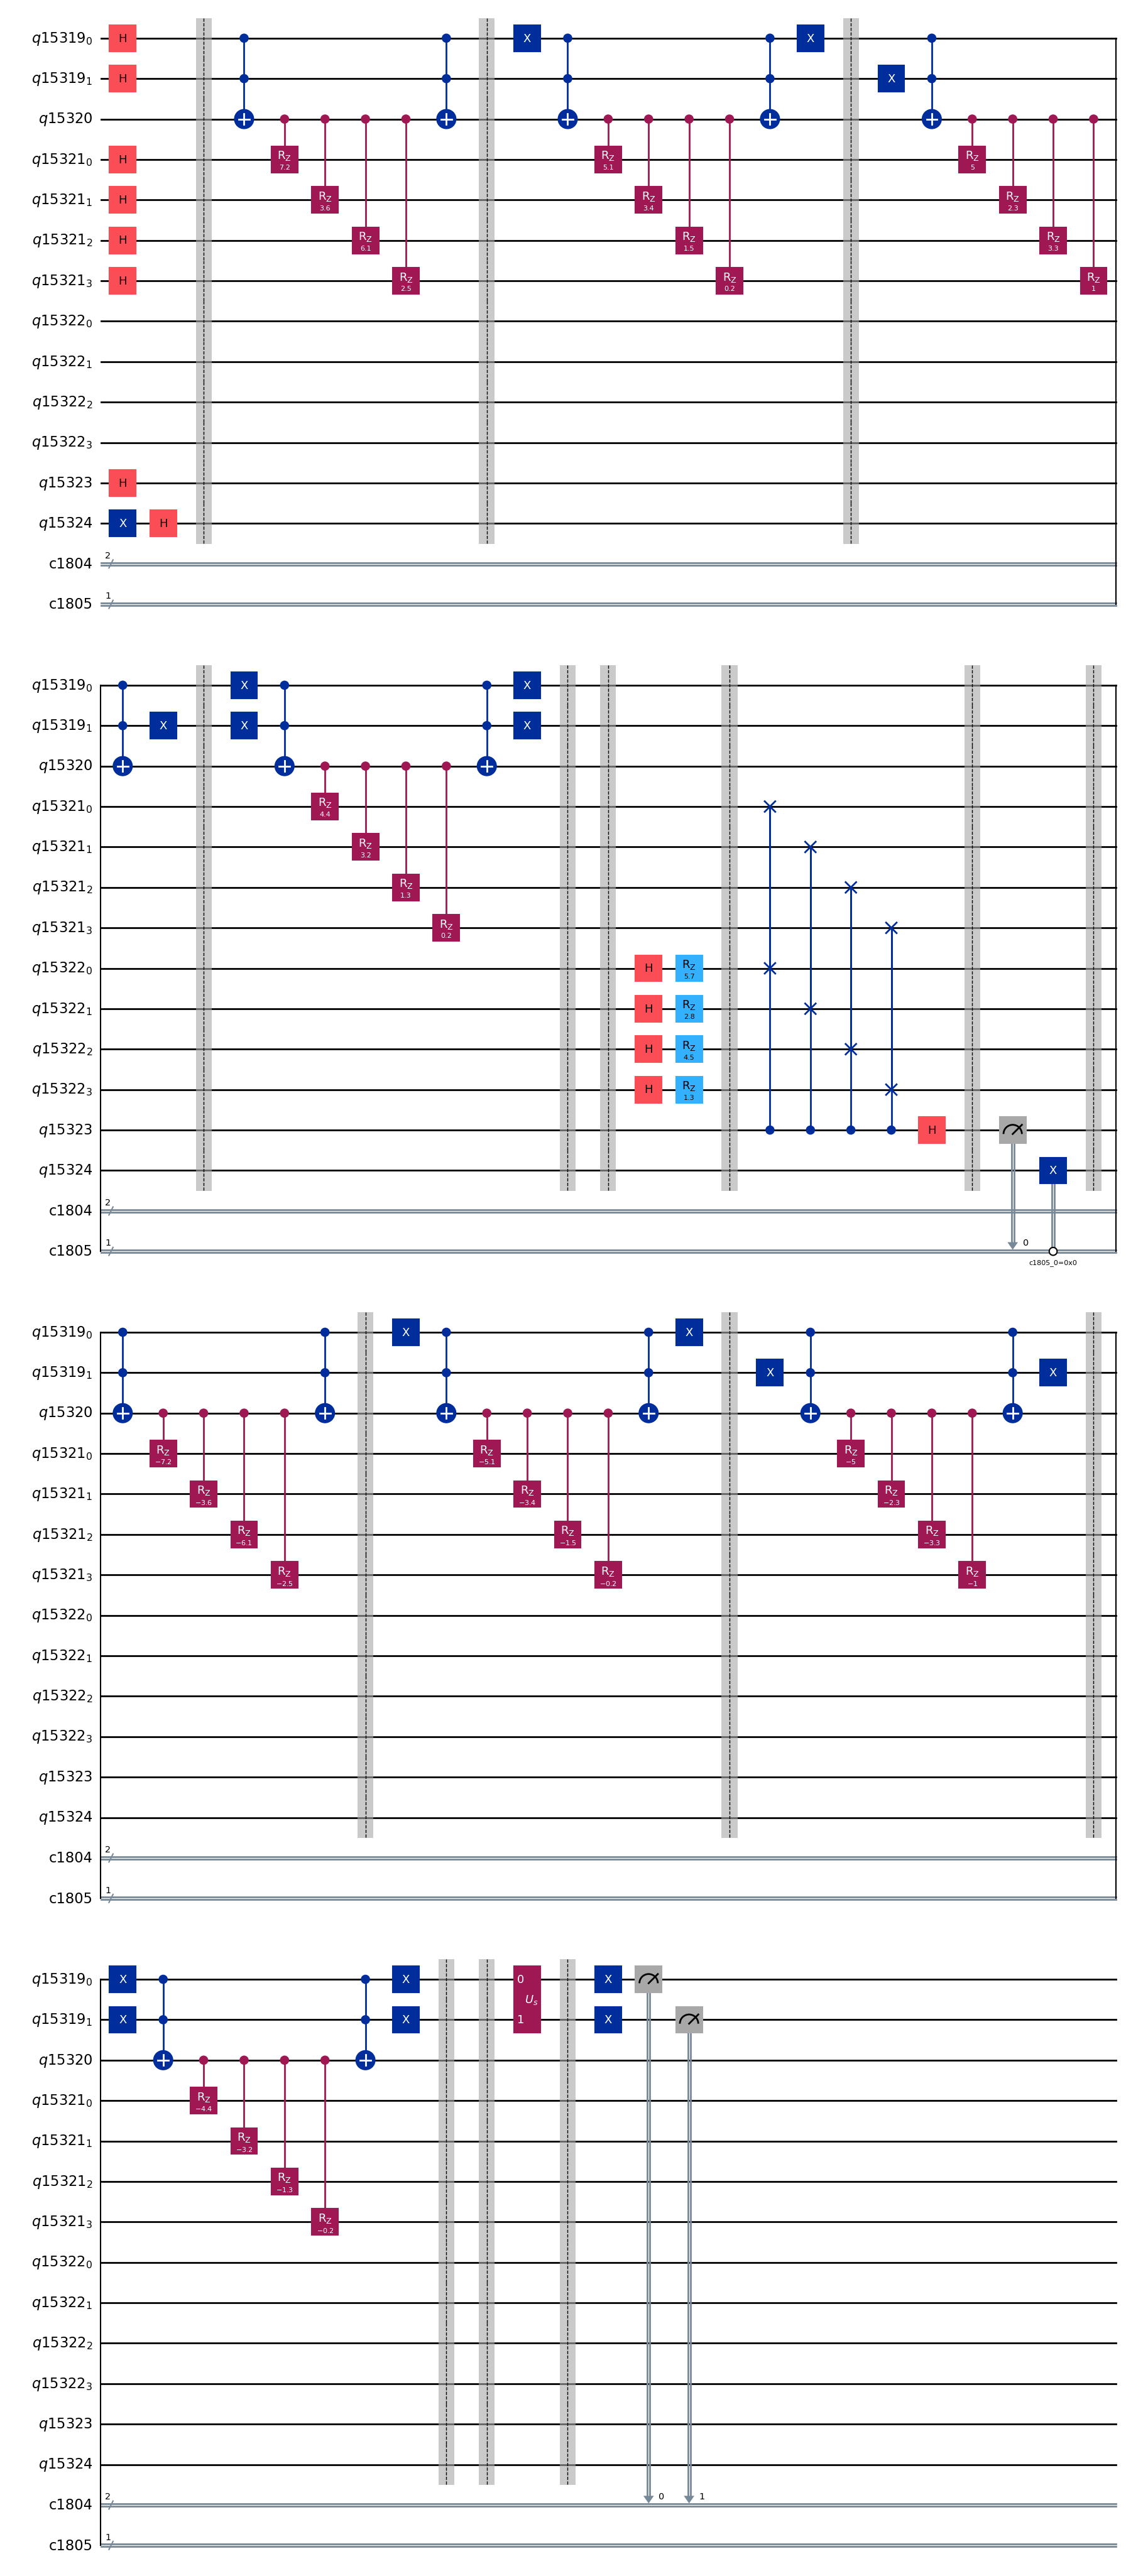

In [21]:
size = 2
qknn(x_test[0], x_train,y_train,size).draw("mpl")

### Experiments

Experiments of the QK-NN with size of QRAM of 8, 16, 32, 64, and 128 cells of memory.

In [22]:
#list of output list 
acc_8 = []
acc_16 = []
acc_32 = []
acc_64 = []
acc_128 = []

experiment_size = 10

min_QRAM = 3
max_QRAM = 5

for iteration in range(experiment_size):
    for size in range(min_QRAM,max_QRAM):
        result_lista = []
        y_pred = []
        counts_l = []
        k = len(y_test)
        for i in range(k):
            qc = qknn(x_test[i], x_train,y_train,size)
            result = AerSimulator().run(transpile(qc,basis_gates=["cx","rz","x","sx"]), shots=8192).result()
            counts = result.get_counts(qc)
            counts_l.append(counts)
            #print(counts)
            salida = '0'
            while salida[0] != '1':
                salida = max(counts.items(), key=operator.itemgetter(1))[0]
                del counts[salida]
            y_pred.append(y_train[int(salida[1:], 2)])
            result_lista.append([y_pred[i], y_test[i]])

        cf_matrix = confusion_matrix(y_test[:k], y_pred)
        acc_knn = ((cf_matrix[0][0]+cf_matrix[1][1]+cf_matrix[2][2])/sum(sum(cf_matrix)))*100
        if size == 3:
            acc_8.append(acc_knn)

        elif size == 4:
            acc_16.append(acc_knn)

        elif size == 5:
            acc_32.append(acc_knn)

        if size == 6:
            acc_64.append(acc_knn)
        else:
            acc_128.append(acc_knn)

        print("train set: ",size,"Accuracy: ",acc_knn)

train set:  3 Accuracy:  82.22222222222221
train set:  4 Accuracy:  91.11111111111111
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  93.33333333333333
train set:  3 Accuracy:  82.22222222222221
train set:  4 Accuracy:  93.33333333333333
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  91.11111111111111
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  91.11111111111111
train set:  3 Accuracy:  82.22222222222221
train set:  4 Accuracy:  93.33333333333333
train set:  3 Accuracy:  82.22222222222221
train set:  4 Accuracy:  88.88888888888889
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  95.55555555555556
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  93.33333333333333
train set:  3 Accuracy:  84.44444444444444
train set:  4 Accuracy:  91.11111111111111


###  Results

In [23]:
def mae_acc(acc):
    mean =  np.mean(np.asarray(acc))
    n = len(acc)
    summ = 0
    for i in range(n):
        summ += abs(mean - acc[i])
    return mean,summ/n



print("The MAE value of each size is ")
for i in range(min_QRAM,max_QRAM):
    mean,error = 0,0
    if i == 3:
        mean,error  = mae_acc(acc_8)
    elif i == 4:
        mean,error  = mae_acc(acc_16)
    elif i == 5:
        mean,error  = mae_acc(acc_32)
    elif i == 6:
        mean,error  = mae_acc(acc_64)
    else:
        mean,error  = mae_acc(acc_128)
        
    print(f'MAE of  QRAM of size {int(2**i)} cells of memory with {mean:.2f} +/- {error:.2f}.')


The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 83.56 +/- 1.07.
MAE of  QRAM of size 16 cells of memory with 92.22 +/- 1.56.
